![hopsworks_logo](../../images/hopsworks_logo.png)

# Part 03: Model training & UI Exploration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_online/3_model_training.ipynb)

In this last notebook, we will train a model on the dataset we created in the previous tutorial. We will train our model using standard Python and Scikit-learn, although it could just as well be trained with other machine learning frameworks such as PySpark, TensorFlow, and PyTorch. We will also show some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided in 5 main sections:
1. **Loading the training data**
2. **Train the model**
3. **Register model to Hopsworks model registry**.
4. **Deploy the model on KServe behind Hopsworks for real-time inference requests**.
5. **Test model deployment and use model serving rest APIs**.

![tutorial-flow](../../images/03_model.png)

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/164


Connected. Call `.close()` to terminate connection gracefully.


---

## <span style="color:#ff5f27;"> ⬇️ Training Dataset retrieval</span>

To retrieve training dataset from **Feature Store** we retrieve **Feature View** using `FeatureStore.get_feature_view` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_training_dataset` method.


In [2]:
nyc_fares_fv = fs.get_feature_view(
    name = 'nyc_taxi_fares_fv',
    version = 1
)

In [3]:
X_train, y_train, X_test, y_test = nyc_fares_fv.get_train_test_split(
    training_dataset_version=2
)

In [4]:
X_test.head(5)

,month_of_the_ride,ride_id,passenger_count,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour
0,197001,d070e81b13f9d4ee015365f50c2b2218,3,25.752523,22.054872,28.265240,30.532599,47.690248,15.095869,31.496596,1970,0,13
1,197001,1f609c564f968ca69591b3e7714c9692,3,63.851680,61.279378,40.410433,74.773954,30.644042,58.522090,29.825254,1970,0,14
2,197001,07645c3c6b9154d6e56ee7d293f9e00f,4,23.301742,74.100019,51.679051,87.120651,63.827367,71.076367,47.910363,1970,0,14
3,197001,da8f1aeb90ae756d4a37816b16754204,1,73.733474,83.076283,9.932646,72.789475,14.184656,72.450431,3.128552,1970,0,14
4,197001,761bb0add35b8a4d4c7e381c218f2b0d,3,33.338616,53.130341,35.018678,54.076853,24.444730,44.094011,24.585567,1970,0,14


In [5]:
cols_to_drop = ['ride_id']

In [6]:
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [7]:
import numpy as np


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [8]:
y_test

array([ 20.,  29.,  35.,  48.,  84., 103., 114., 150., 153., 215., 216.,
       219., 237.])

---

In [9]:
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_absolute_error, r2_score

---

In [10]:
X_test.shape

(13, 12)

## <span style="color:#ff5f27;">🧬 Modeling</span>

In [11]:
# we will not perform hyperparameter tuning cause the data was generated randomly
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [32]:
X_test.columns

Index(['month_of_the_ride', 'passenger_count', 'distance',
       'pickup_distance_to_jfk', 'dropoff_distance_to_jfk',
       'pickup_distance_to_ewr', 'dropoff_distance_to_ewr',
       'pickup_distance_to_lgr', 'dropoff_distance_to_lgr', 'year', 'weekday',
       'hour'],
      dtype='object')

In [12]:
lr_preds = lr_model.predict(X_test)

lr_r2_score = r2_score(y_test, lr_preds)
lr_mae = mean_absolute_error(y_test, lr_preds)

print("LogisticRegression R²:", lr_r2_score)
print("LogisticRegression MAE:", lr_mae)

LogisticRegression R²: -0.6639530938590095
LogisticRegression MAE: 84.15384615384616


### Remember, our data is random, so the results are not accurate at all.

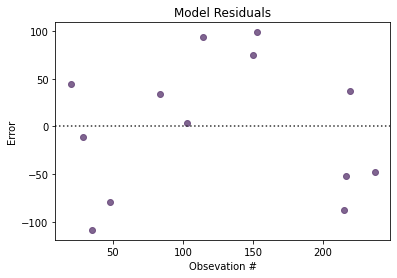

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.residplot(y_test, lr_preds, color='#613F75')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()

---

## <span style="color:#ff5f27;">📝 Register model in Hopsworks</span>

One of the features in Hopsworks is the model registry. This is where we can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

Let's connect to the model registry using the [HSML library](https://docs.hopsworks.ai/machine-learning-api/latest) from Hopsworks.

In [14]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


Before registering the model we will export it as a pickle file using joblib.

In [15]:
import joblib

joblib.dump(lr_model, 'model.pkl')

['model.pkl']

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [16]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'month_of_the_ride',
    'type': 'int64'},
   {'name': 'passenger_count', 'type': 'int64'},
   {'name': 'distance', 'type': 'float64'},
   {'name': 'pickup_distance_to_jfk', 'type': 'float64'},
   {'name': 'dropoff_distance_to_jfk', 'type': 'float64'},
   {'name': 'pickup_distance_to_ewr', 'type': 'float64'},
   {'name': 'dropoff_distance_to_ewr', 'type': 'float64'},
   {'name': 'pickup_distance_to_lgr', 'type': 'float64'},
   {'name': 'dropoff_distance_to_lgr', 'type': 'float64'},
   {'name': 'year', 'type': 'int64'},
   {'name': 'weekday', 'type': 'int64'},
   {'name': 'hour', 'type': 'int64'}]},
 'output_schema': {'tensor_schema': {'shape': '(87,)', 'type': 'float64'}}}

With the schema in place, we can finally register our model.

In [17]:
metrics = {
    'mae': lr_mae,
    'r2_score': lr_r2_score
}


In [18]:
model = mr.sklearn.create_model(
    name="nyc_taxi_fares_model",
    metrics=metrics,
    description="LogisticRegression.",
    input_example=X_test.sample(),
    model_schema=model_schema
)

model.save('model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/164/models/nyc_taxi_fares_model/1


Model(name: 'nyc_taxi_fares_model', version: 1)

In [19]:
# how to get a best model (when you have many of them)

# EVALUATION_METRIC="mae"  # or r2_score
# SORT_METRICS_BY="max" # your sorting criteria

# # get best model based on custom metrics
# best_model = mr.get_best_model("nyc_taxi_fares_model",
#                                EVALUATION_METRIC,
#                                SORT_METRICS_BY)

Here we have also saved an input example from the training data, which can be helpful for test purposes.

It's important to know that every time you save a model with the same name, a new version of the model will be saved, so nothing will be overwritten. In this way, you can compare several versions of the same model - or create a model with a new name, if you prefer that.

## <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> 🚀 Model Deployment</a>

In [20]:
# %%writefile predict_example.py
# import os
# import joblib
# import numpy as np
# import pandas as pd

# import hopsworks


# class Predict(object):

#     def __init__(self):
#         """ Initializes the serving state, reads a trained model"""        
#         # get feature store handle
#         project = hopsworks.login()
#         self.fs = project.get_feature_store()
        
#         # load the trained model
#         self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/model.pkl")
#         print("Initialization Complete")

#     def predict(self, inputs):
#         """ Serves a prediction request usign a trained model"""
#         return self.model.predict(np.array(inputs).reshape(1, -1)).tolist()

In [21]:
# import os

# # it may fail when you run it for the first time
# # just rerun this cell once again

# dataset_api = project.get_dataset_api()

# uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
# predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

In [22]:
# On cluster, I have created this file manually cause it was not creating by itself

# predictor_script_path = f'hdfs:///Projects/{fs.project_name}/Jupyter/predict_example.py'

In [23]:
# # check if it looks correct

# predictor_script_path

In [24]:
# # since on my Windows it generated incorrectly, I will fix it manually.
# predictor_script_path = '/Projects/romankah/Models/predict_example.py'

---

## 📡 Create the deployment
Here, we fetch the model we want from the model registry and define a configuration for the deployment. For the configuration, we need to specify the serving type (default or KFserving) and in this case, since we use default serving and an sklearn model, we need to give the location of the prediction script.

In [ ]:
# # Give it any name you want
# deployment = model.deploy(
#     name="nyctaxifares", 
#     model_server="PYTHON",
#     script_file=predictor_script_path,
#     serving_tool="KSERVE"
# )

In [26]:
# print("Deployment: " + deployment.name)
# deployment.describe()

### The deployment has now been registered. However, to start it you need to run:

In [27]:
# deployment.start()

In [28]:
# deployment.get_logs()

## <span style='color:#ff5f27'>🔮 Predicting using deployment</span>

In [29]:
# model.input_example

In [30]:
# data = {
#     "inputs": model.input_example
# }

# deployment.predict(data)

In [31]:
# deployment.stop()

---

## <span style="color:#ff5f27;"> 🎁  Wrapping things up </span>

We have now performed a simple training with training data that we have created in the feature store. This concludes the fisrt module and introduction to the core aspect of the Feature store. In the second module we will introduce streaming and external feature groups for a similar fraud use case.